<a href="https://colab.research.google.com/github/Kabilan-T/NLP_project/blob/main/NLP_project_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Collecting and Performing Sentimental Analysis on Tweet**

**Team Members :**
1. Kabilan Tamilmani
2. Vishwas Sharma
3. Karthik Sundararaj

**Overview :** 
\
\
Sentiment analysis is a process to identify and classify the message in text data. The message is subjective information about a particular topic. The most common type of classification in sentiment analysis is polarity detection (positive, negative, or neutral). Data available in non-traditional sources such as reviews and social media posts can be valuable if we could perform sentiment analysis. With this analysis, an organization can gather feedback about their new products and services or measure their marketing impact and make decisions in real-time.
\
\
Our idea is to develop a project which can collect tweets about the given topic from Twitter, pre-process them and perform sentiment analysis over the pre-processed data. This could give us valuable information such as what the people feel about the particular topic and the most common messages (an appreciation or critic) from the social media community

## Imports

In [ ]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
 
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
 
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
 
 
# Word2vec
import gensim
 
# Twitter api
import tweepy
 
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline
 
# Utility
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
import re
import csv
import string
import pickle
import itertools
from collections import Counter
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Setting model parameters

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
LABEL_DECODE_MAP = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
SAMPLE_SIZE = 50000
TRAIN_SIZE = 0.8
 
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
 
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10
 
# FASTTEXT 
FT_SIZE = 300
FT_WINDOW = 7
FT_EPOCH = 32
FT_MIN_COUNT = 10
 
# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024
 
# SENTIMENT
SENTIMENT_THRESHOLDS = (0.4, 0.7)
 
# EXPORT
KERAS_W2V_MODEL = "my_keras_w2v_model.h5"
KERAS_FT_MODEL = "my_keras_ft_model.h5"
WORD2VEC_MODEL = "my_w2v_model.w2v"
FASTTEXT_MODEL = "my_fasttext_model.w2v"
TOKENIZER_MODEL = "my_tokenizer.pkl"
ENCODER_MODEL = "my_encoder.pkl"
 
# STOP WORDS
stop_words = stopwords.words("english")

## Preparing Dataset

Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = os.path.join("/content/drive/MyDrive/NLP PROJECT/training.1600000.processed.noemoticon.csv")
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, 
                 encoding ="ISO-8859-1" , 
                 names=DATASET_COLUMNS)
print("Dataset size:", len(df))

Open file: /content/drive/MyDrive/NLP PROJECT/training.1600000.processed.noemoticon.csv
Dataset size: 1600000


Assigning labels to the tweets based on their polarity\
(0 = Negative, 2 = Neutral, 4 = Positive)

In [ ]:
df.target = df.target.apply(lambda label: LABEL_DECODE_MAP[int(label)])

Total Dataset labels distribuition

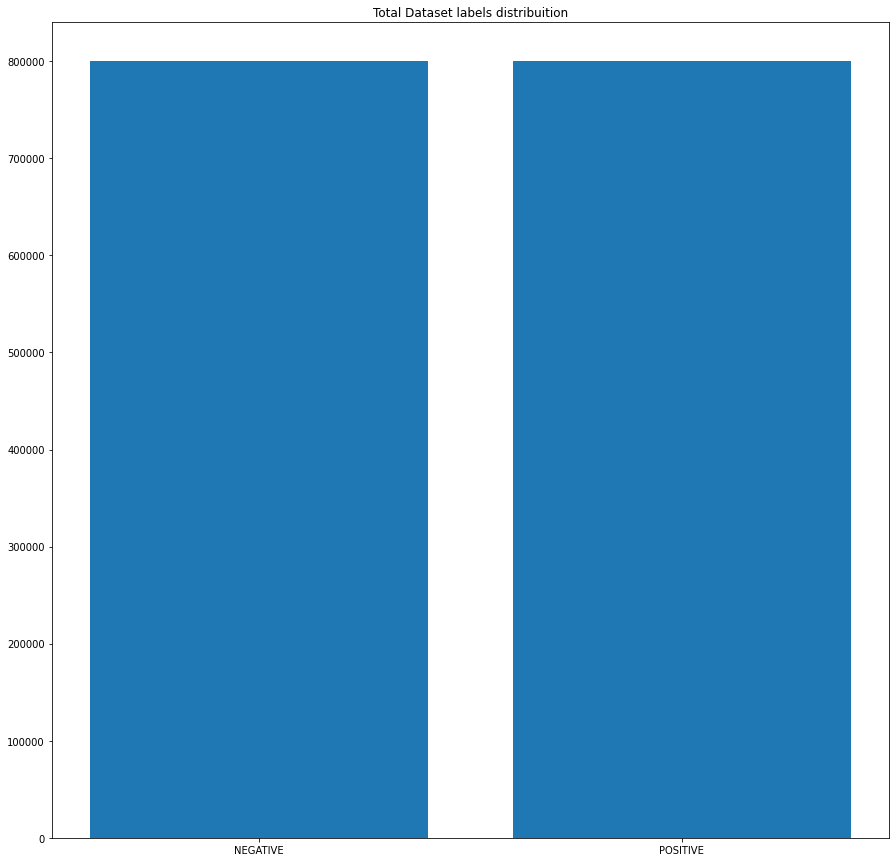

In [ ]:
target_cnt = Counter(df.target)
plt.figure(figsize=(15,15))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Total Dataset labels distribuition")
plt.show()

Filtering a sample out of the large dataset

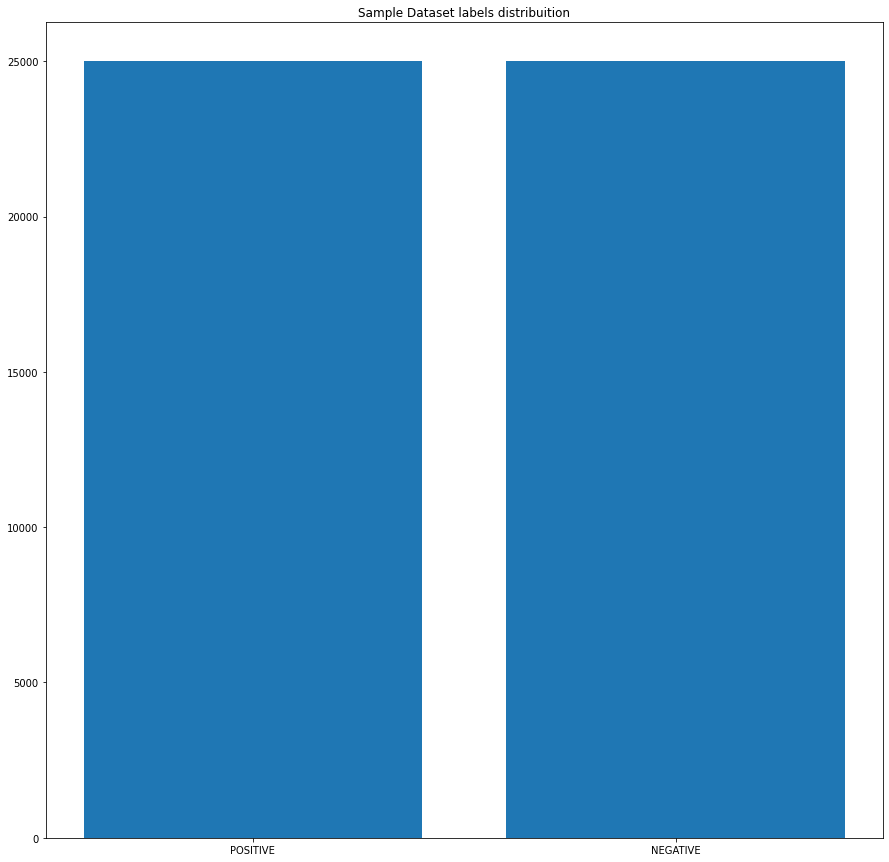

In [ ]:
# Seperating Positive and negative label data
df_positive = df.loc[np.where(df['target'] == "POSITIVE")]
df_negative = df.loc[np.where(df['target'] == "NEGATIVE")]
# Shuffling dataframes
df_positive = df_positive.sample(frac=1)[:int(SAMPLE_SIZE/2)]
df_negative = df_negative.sample(frac=1)[:int(SAMPLE_SIZE/2)]
# Merging postive and negative label sets and shuffling
df = pd.concat([df_positive,df_negative])
df = df.sample(frac=1)

target_cnt = Counter(df.target)
plt.figure(figsize=(15,15))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Sample Dataset labels distribuition")
plt.show()

## Pre-processing the dataset

In [ ]:
df.head(10)

,target,ids,date,flag,user,text
1277009,POSITIVE,2001270470,Tue Jun 02 00:20:56 PDT 2009,NO_QUERY,PrinceYoung01,Check out my YouTube Channel I know all my You...
1243590,POSITIVE,1994610353,Mon Jun 01 12:11:16 PDT 2009,NO_QUERY,lillypauline,@Baleyrocks23 Oh i know how it's horrible - i ...
931079,POSITIVE,1770716425,Mon May 11 22:03:16 PDT 2009,NO_QUERY,ColorBakery,@donhough u2
1191094,POSITIVE,1983829239,Sun May 31 13:55:04 PDT 2009,NO_QUERY,KatieHeidie,one full week of school left and then done (pl...
265885,NEGATIVE,1988885047,Sun May 31 23:39:57 PDT 2009,NO_QUERY,Beckyrudd,@maisizzle arghhhh! I know
1547374,POSITIVE,2182707970,Mon Jun 15 13:31:48 PDT 2009,NO_QUERY,weecycleme,Carter's baby sale up to 70% off. Plus coupon...
1526982,POSITIVE,2177115967,Mon Jun 15 05:28:58 PDT 2009,NO_QUERY,LexiePixie,"@MMartin ohhh, sorry . But you can always make..."
811207,POSITIVE,1469985904,Tue Apr 07 08:00:36 PDT 2009,NO_QUERY,andrewin3d,@joepending tell him i say hi
413766,NEGATIVE,2060663384,Sat Jun 06 19:20:10 PDT 2009,NO_QUERY,BimmerSeven,watching the Redwings beat up the Penguins. Wi...
1355556,POSITIVE,2047484512,Fri Jun 05 13:43:17 PDT 2009,NO_QUERY,mblandiniii,Photo: gabe looks so young. so cute. i love th...


Function to Pre-procerss a single tweet (i.e Remove Mentions, Links, Hashtags)

In [ ]:
def preprocess_tweet(tweet):
  # Remove link, user and special characters in the unprocessed tweet
  tweet = re.sub(TEXT_CLEANING_RE, ' ', str(tweet).lower()).strip()
  processed_words = []
  lemmatizer = WordNetLemmatizer()
  for word in tweet.split():
    if word not in stop_words:
      processed_words.append(word)

  # Lemmatizing the tokens
  processed_token = []
  for token, tag in pos_tag(processed_words):
    if tag.startswith("NN"):
        pos = 'n'
    elif tag.startswith('VB'):
        pos = 'v'
    else:
        pos = 'a'
    token = lemmatizer.lemmatize(token, pos)
    processed_token.append(token)

  #Final preprocessed tweet
  processed_tweet = " ".join(processed_token)
  return processed_tweet



In [ ]:
df.text = df.text.apply(lambda x: preprocess_tweet(x))
df.head(10)

,target,ids,date,flag,user,text
1277009,POSITIVE,2001270470,Tue Jun 02 00:20:56 PDT 2009,NO_QUERY,PrinceYoung01,check youtube channel know youtube family miss...
1243590,POSITIVE,1994610353,Mon Jun 01 12:11:16 PDT 2009,NO_QUERY,lillypauline,oh know horrible hope feel good
931079,POSITIVE,1770716425,Mon May 11 22:03:16 PDT 2009,NO_QUERY,ColorBakery,u2
1191094,POSITIVE,1983829239,Sun May 31 13:55:04 PDT 2009,NO_QUERY,KatieHeidie,one full week school leave do plus exams get mind
265885,NEGATIVE,1988885047,Sun May 31 23:39:57 PDT 2009,NO_QUERY,Beckyrudd,arghhhh know
1547374,POSITIVE,2182707970,Mon Jun 15 13:31:48 PDT 2009,NO_QUERY,weecycleme,carter baby sale 70 plus coupon extra 20 june ...
1526982,POSITIVE,2177115967,Mon Jun 15 05:28:58 PDT 2009,NO_QUERY,LexiePixie,ohhh sorry always make another one right
811207,POSITIVE,1469985904,Tue Apr 07 08:00:36 PDT 2009,NO_QUERY,andrewin3d,tell say hi
413766,NEGATIVE,2060663384,Sat Jun 06 19:20:10 PDT 2009,NO_QUERY,BimmerSeven,watch redwing beat penguin wish way
1355556,POSITIVE,2047484512,Fri Jun 05 13:43:17 PDT 2009,NO_QUERY,mblandiniii,photo gabe look young cute love


## Train and Test Dataset

Train and Test split

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 40000
TEST size: 10000


Tokenizer

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words in the Vocalbulary", vocab_size)

Total words in the Vocalbulary 29336
CPU times: user 605 ms, sys: 8.85 ms, total: 614 ms
Wall time: 616 ms


In [ ]:
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0) #Saving Tokenizer

Padding

In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 814 ms, sys: 6.97 ms, total: 821 ms
Wall time: 821 ms


Reshaping X and Y of train and test datasets

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("X Train", x_train.shape)
print("Y Train", y_train.shape)
print("X Test", x_test.shape)
print("Y Test", y_test.shape)

X Train (40000, 300)
Y Train (40000, 1)
X Test (10000, 300)
Y Test (10000, 1)


In [ ]:
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0) #Saving Encoder

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time
train_size = 5000
test_size = 1000
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(x_train[:train_size], y_train[:train_size])
predictions = text_classifier.predict(x_test[:test_size])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


CPU times: user 2.66 s, sys: 19.6 ms, total: 2.68 s
Wall time: 2.69 s


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test[:test_size],predictions))
print(classification_report(y_test[:test_size],predictions))
print(accuracy_score(y_test[:test_size], predictions))

[[304 206]
 [247 243]]
              precision    recall  f1-score   support

           0       0.55      0.60      0.57       510
           1       0.54      0.50      0.52       490

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000

0.547


## Embeddings

Document

In [ ]:
documents = [tweet.split() for tweet in df_train.text] 

### Word2Vec Model

Model initialize

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

Building model

In [ ]:
w2v_model.build_vocab(documents)

Training model

In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 31.5 s, sys: 253 ms, total: 31.7 s
Wall time: 17 s


(6760552, 9229152)

Saving Model

In [ ]:
w2v_model.save(WORD2VEC_MODEL)

### FastText Model

Model Initialize

In [ ]:
ft_model = gensim.models.FastText(size=FT_SIZE, 
                                  window=FT_WINDOW, 
                                  min_count=FT_MIN_COUNT, 
                                  workers=8)

Building model

In [ ]:
ft_model.build_vocab(documents)

Training Model

In [ ]:
%%time
ft_model.train(documents, total_examples=len(documents), epochs=FT_EPOCH)

CPU times: user 1min 50s, sys: 375 ms, total: 1min 51s
Wall time: 57.6 s


Saving Model

In [ ]:
ft_model.save(FASTTEXT_MODEL)

## Sentiment Models

### Word2Vec Model

Embedding Layer

In [ ]:
embedding_matrix_w2v = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix_w2v[i] = w2v_model.wv[word]
print(embedding_matrix_w2v.shape)

(29130, 300)


In [ ]:
embedding_layer_w2v = Embedding(vocab_size, W2V_SIZE, 
                                weights=[embedding_matrix_w2v], 
                                input_length=SEQUENCE_LENGTH, 
                                trainable=False,
                                name='EmbeddingLayer_WORD2VEC')

Other layers

In [ ]:
dropout = Dropout(0.5)
lstm = LSTM(100, dropout=0.2, recurrent_dropout=0.2)
dense = Dense(1, activation='sigmoid')

Building model

In [ ]:
model_w2v = Sequential(name= "SentimentModel_WORD2VEC")
model_w2v.add(embedding_layer_w2v)
model_w2v.add(dropout)
model_w2v.add(lstm)
model_w2v.add(dense)
model_w2v.summary()

Model: "SentimentModel_WORD2VEC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EmbeddingLayer_WORD2VEC (Emb (None, 300, 300)          8739000   
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 8,899,501
Trainable params: 160,501
Non-trainable params: 8,739,000
_________________________________________________________________


Compiling model

In [ ]:
model_w2v.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

Fitting train dataset to the model

In [ ]:
%%time
history_w2v = model_w2v.fit(x_train, y_train,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            validation_split=0.1,
                            verbose=1,
                            callbacks=callbacks)

Epoch 1/8
36/36 [==============================] - 465s 12s/step - loss: 0.6413 - accuracy: 0.6151 - val_loss: 0.5368 - val_accuracy: 0.7310
Epoch 2/8
36/36 [==============================] - 442s 12s/step - loss: 0.5633 - accuracy: 0.7082 - val_loss: 0.5283 - val_accuracy: 0.7360
Epoch 3/8
36/36 [==============================] - 440s 12s/step - loss: 0.5547 - accuracy: 0.7132 - val_loss: 0.5294 - val_accuracy: 0.7405
Epoch 4/8
36/36 [==============================] - 441s 12s/step - loss: 0.5488 - accuracy: 0.7198 - val_loss: 0.5246 - val_accuracy: 0.7442
Epoch 5/8
36/36 [==============================] - 442s 12s/step - loss: 0.5394 - accuracy: 0.7260 - val_loss: 0.5188 - val_accuracy: 0.7460
Epoch 6/8
36/36 [==============================] - 441s 12s/step - loss: 0.5362 - accuracy: 0.7237 - val_loss: 0.5166 - val_accuracy: 0.7452
Epoch 7/8
36/36 [==============================] - 440s 12s/step - loss: 0.5296 - accuracy: 0.7319 - val_loss: 0.5141 - val_accuracy: 0.7452
Epoch 8/8
36/

Saving Sentiment model

In [ ]:
model_w2v.save(KERAS_W2V_MODEL)

#### Evaluation

Accuracy and Loss

In [ ]:
%%time
score = model_w2v.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 25s 2s/step - loss: 0.5224 - accuracy: 0.7403
ACCURACY: 0.7402999997138977
LOSS: 0.5224227905273438
CPU times: user 45.6 s, sys: 2.17 s, total: 47.8 s
Wall time: 41 s


Plot History of accuracy and Loss

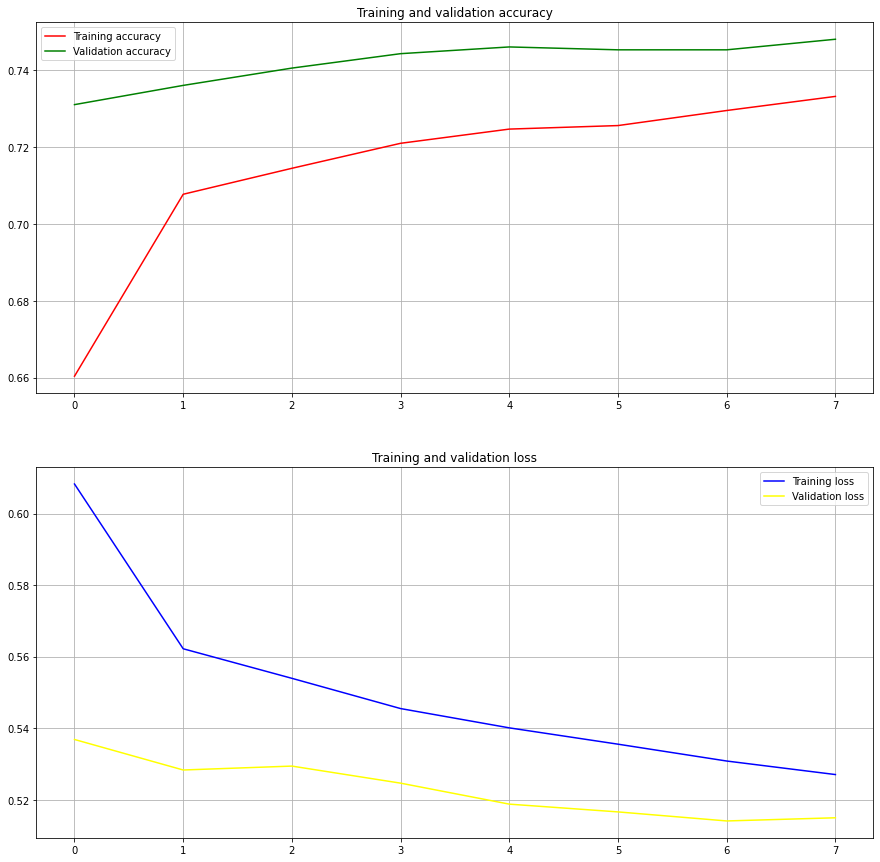

In [ ]:
acc = history_w2v.history['accuracy']
val_acc = history_w2v.history['val_accuracy']
loss = history_w2v.history['loss']
val_loss = history_w2v.history['val_loss']
epochs = range(len(acc))

# Plotting
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax1.plot(epochs, acc, 'red', label='Training accuracy')
ax1.plot(epochs, val_acc, 'green', label='Validation accuracy')
ax1.set(title='Training and validation accuracy')
ax1.grid()
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.plot(epochs, loss, 'blue', label='Training loss')
ax2.plot(epochs, val_loss, 'yellow', label='Validation loss')
ax2.set(title='Training and validation loss')
ax2.grid()
ax2.legend()
 
plt.show()

### FastText Model

Embedding Layer

In [ ]:
embedding_matrix_ft = np.zeros((vocab_size, FT_SIZE))
for word, i in tokenizer.word_index.items():
    if word in ft_model.wv:
        embedding_matrix_ft[i] = ft_model.wv[word]
print(embedding_matrix_ft.shape)

(29130, 300)


In [ ]:
embedding_layer_ft = Embedding(vocab_size, FT_SIZE, 
                              weights=[embedding_matrix_ft], 
                              input_length=SEQUENCE_LENGTH, 
                              trainable=False,
                              name='EmbeddingLayer_FASTTEXT')

Other layers

In [ ]:
dropout = Dropout(0.5)
lstm = LSTM(100, dropout=0.2, recurrent_dropout=0.2)
dense = Dense(1, activation='sigmoid')

Building model

In [ ]:
model_ft = Sequential(name= "SentimentModel_FASTTEXT")
model_ft.add(embedding_layer_ft)
model_ft.add(dropout)
model_ft.add(lstm)
model_ft.add(dense)
model_ft.summary()

Model: "SentimentModel_FASTTEXT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EmbeddingLayer_FASTTEXT (Emb (None, 300, 300)          8739000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 8,899,501
Trainable params: 160,501
Non-trainable params: 8,739,000
_________________________________________________________________


Compiling model

In [ ]:
model_ft.compile(loss='binary_crossentropy',
                 optimizer="adam",
                metrics=['accuracy'])
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

Fitting train dataset to the model

In [ ]:
%%time
history_ft = model_ft.fit(x_train, y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          validation_split=0.1,
                          verbose=1,
                          callbacks=callbacks)

Epoch 1/8
36/36 [==============================] - 443s 12s/step - loss: 0.6407 - accuracy: 0.6189 - val_loss: 0.5552 - val_accuracy: 0.7168
Epoch 2/8
36/36 [==============================] - 440s 12s/step - loss: 0.5698 - accuracy: 0.7019 - val_loss: 0.5366 - val_accuracy: 0.7358
Epoch 3/8
36/36 [==============================] - 439s 12s/step - loss: 0.5603 - accuracy: 0.7098 - val_loss: 0.5326 - val_accuracy: 0.7355
Epoch 4/8
36/36 [==============================] - 440s 12s/step - loss: 0.5506 - accuracy: 0.7170 - val_loss: 0.5308 - val_accuracy: 0.7368
Epoch 5/8
36/36 [==============================] - 440s 12s/step - loss: 0.5391 - accuracy: 0.7295 - val_loss: 0.5243 - val_accuracy: 0.7408
Epoch 6/8
36/36 [==============================] - 441s 12s/step - loss: 0.5359 - accuracy: 0.7262 - val_loss: 0.5242 - val_accuracy: 0.7380
Epoch 7/8
36/36 [==============================] - 441s 12s/step - loss: 0.5328 - accuracy: 0.7318 - val_loss: 0.5190 - val_accuracy: 0.7435
Epoch 8/8
36/

Saving Sentiment model

In [ ]:
model_ft.save(KERAS_FT_MODEL)

#### Evaluation

Accuracy and Loss

In [ ]:
%%time
score = model_ft.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 25s 2s/step - loss: 0.5310 - accuracy: 0.7355
ACCURACY: 0.7354999780654907
LOSS: 0.5309511423110962
CPU times: user 45.4 s, sys: 2.13 s, total: 47.5 s
Wall time: 24.7 s


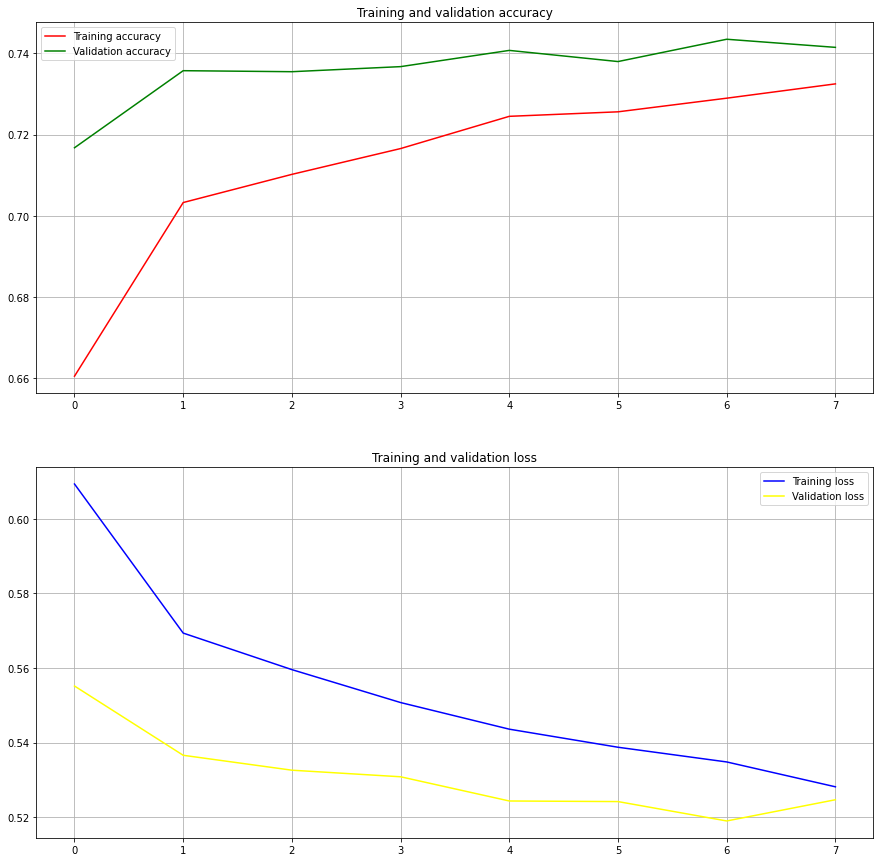

In [ ]:
acc = history_ft.history['accuracy']
val_acc = history_ft.history['val_accuracy']
loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']
epochs = range(len(acc))

# Plotting
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax1.plot(epochs, acc, 'red', label='Training accuracy')
ax1.plot(epochs, val_acc, 'green', label='Validation accuracy')
ax1.set(title='Training and validation accuracy')
ax1.grid()
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.plot(epochs, loss, 'blue', label='Training loss')
ax2.plot(epochs, val_loss, 'yellow', label='Validation loss')
ax2.set(title='Training and validation loss')
ax2.grid()
ax2.legend()
 
plt.show()

## Sentiment Analysis

**After evaluating both the embedding models. we found that WORD2VEC embedding model performance is slightly better than that of FASTTEXT model. So we are going to use WORD2VEC model for our analysis**

#### Loading Model

In [ ]:
model_path = os.path.join("/content/drive/MyDrive/NLP PROJECT/"+KERAS_W2V_MODEL)
tokenizer_path = os.path.join("/content/drive/MyDrive/NLP PROJECT/"+TOKENIZER_MODEL)
model = load_model(model_path)
tokenizer = pickle.load(open(tokenizer_path, 'rb'))

### Prediction Function

In [ ]:
def decode_sentiment(score, include_neutral=True):
  if include_neutral:        
    if score <= SENTIMENT_THRESHOLDS[0]: label = "NEGATIVE"
    elif score >= SENTIMENT_THRESHOLDS[1]: label = "POSITIVE"
    else : label = "NEUTRAL"
    return label
  else:
    return "NEGATIVE" if score < 0.5 else "POSITIVE"

### Evaluation metrics and confusion_matrix

In [ ]:
def evaluation(y_hat,Y_test):
    # Classification report
    print("\n Classification Report")
    print(metrics.classification_report(Y_test, y_hat))
    # Accuracy
    accuracy = metrics.accuracy_score(Y_test, y_hat)
    print(f'Accuracy :{accuracy*100:.2f}%')
    # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(Y_test,y_hat)
    df_confusion = pd.crosstab(index=[Y_test],columns=[y_hat], rownames=['Actual'], colnames=['Predicted'])
    # ploting heatmap of Confusion Matrix
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set(title="Confusion Matrix")
    sns.heatmap(df_confusion,annot=True,fmt='d',cmap='Blues')
    plt.show()

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]
 
evaluation(y_pred_1d,y_test_1d)

InvalidArgumentError: ignored

### Twitter API

In [ ]:
consumer_key = "3bjTLuNoNNmJ38PDwu73zZf7H"
consumer_secret = "PuQK0cDKh45xrf6qNV5NIMYff9HQSRDjKmCr62MY3D9JbvQmbM"
access_key= "825051565685874688-QpPfgxkrwc0UbZeeWH18EF5xRMJMNyq"
access_secret = "gWCSzqPZWFDHPuOoh62tbcnSqmtIeFXJY21YE36ICdYR1"

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

### Collecting Tweets from Twitter

In [ ]:
MyTopic = "Pfizer"      # Topic of tweets to be collected
Tweets_count = 100       # No of tweets need to be collected

In [ ]:
%%time
search_term = "#"+MyTopic+" -filter:retweets"
tweets = tweepy.Cursor(api.search, q=search_term, count=100, lang="en", since_id=0).items(Tweets_count)

CPU times: user 430 µs, sys: 0 ns, total: 430 µs
Wall time: 450 µs


In [ ]:
tweet_texts = [tweet.text for tweet in tweets]
tweet_texts[:10]

['#Israel to ship 700K #Pfizer #vaccine doses to #SouthKorea in swap deal.\n\nhttps://t.co/AadZVxTHAI',
 '@lisa_iannattone The thing I\'d take issue with here is "eligible by September". #Pfizer has stated its intention to… https://t.co/MNoZ87ryOq',
 'Just listened to an interview with Dr.Jane Ruby &amp; she stated,  there is Graphine Oxide, in the Ph. shot...\nTruth se… https://t.co/TC8xrndBg9',
 '#Israel agrees to deliver about 700,000 expiring doses of #Pfizer-BioNTech’s coronavirus vaccine to #SouthKorea lat… https://t.co/uaiKEfylFv',
 'BREAKING DISCOVERY! The ACTUAL CONTENTS Inside #Pfizer Vials EXPOSED! https://t.co/N8lGQzALrg',
 '@Teodrose_Fikre\n\n @LSW12612672511\nThe #Pfizer jab is poison (sample size one, too big a mistake to be a mistake)… https://t.co/2ckC504IH4',
 '#Israel has struck a deal to provide #SouthKorea with #Pfizer vaccines in return for jabs in a future shipment.… https://t.co/T9tQIwGHbB',
 'Israel study suggests #Pfizer/BioNTech #vaccine is less effective aga

### Predicting Tweets

In [ ]:
def preprocess_tweet(tweet):
  # Remove link, user and special characters in the unprocessed tweet
  tweet = re.sub(TEXT_CLEANING_RE, ' ', str(tweet).lower()).strip()
  processed_words = []
  lemmatizer = WordNetLemmatizer()
  for word in tweet.split():
    if word not in stop_words:
      processed_words.append(word)

  # Lemmatizing the tokens
  processed_token = []
  for token, tag in pos_tag(processed_words):
    if tag.startswith("NN"):
        pos = 'n'
    elif tag.startswith('VB'):
        pos = 'v'
    else:
        pos = 'a'
    token = lemmatizer.lemmatize(token, pos)
    processed_token.append(token)

  #Final preprocessed tweet
  processed_tweet = " ".join(processed_token)
  return processed_tweet
  
def decode_sentiment(score, include_neutral=True):
  if include_neutral:        
    if score <= SENTIMENT_THRESHOLDS[0]: label = "NEGATIVE"
    elif score >= SENTIMENT_THRESHOLDS[1]: label = "POSITIVE"
    else : label = "NEUTRAL"
    return label
  else:
    return "NEGATIVE" if score < 0.5 else "POSITIVE"
 
def predict_tweet(text, include_neutral=True):
  # Tokenize text
  x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
  # Predict
  score = model.predict([x_test])[0]
  # Decode sentiment
  label = decode_sentiment(score, include_neutral=include_neutral)
  return {"label": label, "score": float(score)}

In [ ]:
score = list()
label = list()
for tweet_text in tweet_texts: 
  processed_tweet = preprocess_tweet(tweet_text)
  prediction = predict_tweet(processed_tweet,include_neutral=False)
  score.append(prediction['score'])
  label.append(prediction['label'])
data = [[t,l,s] for t,l,s in zip(tweet_texts,label,score)]
df = pd.DataFrame(data=data, columns=["tweets", "label", "score"])
df.head(10)

,tweets,label,score
0,#Israel to ship 700K #Pfizer #vaccine doses to...,POSITIVE,0.630727
1,@lisa_iannattone The thing I'd take issue with...,POSITIVE,0.508434
2,Just listened to an interview with Dr.Jane Rub...,POSITIVE,0.776728
3,"#Israel agrees to deliver about 700,000 expiri...",POSITIVE,0.671534
4,BREAKING DISCOVERY! The ACTUAL CONTENTS Inside...,NEGATIVE,0.359944
5,@Teodrose_Fikre\n\n @LSW12612672511\nThe #Pfiz...,POSITIVE,0.705316
6,#Israel has struck a deal to provide #SouthKor...,POSITIVE,0.626390
7,Israel study suggests #Pfizer/BioNTech #vaccin...,POSITIVE,0.708549
8,Stew Peters Show: #Pfizer Jab Contents EXPOSED...,POSITIVE,0.732866
9,"@007QaQa @ShaikhN81421685 Hey, we’re all about...",POSITIVE,0.844091


Save results

In [ ]:
df.to_csv(MyTopic+'.csv')

### Analysis

No. of tweets with POSITIVE sentiment in the collected set :  78
No. of tweets with NEGATIVE sentiment in the collected set 22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


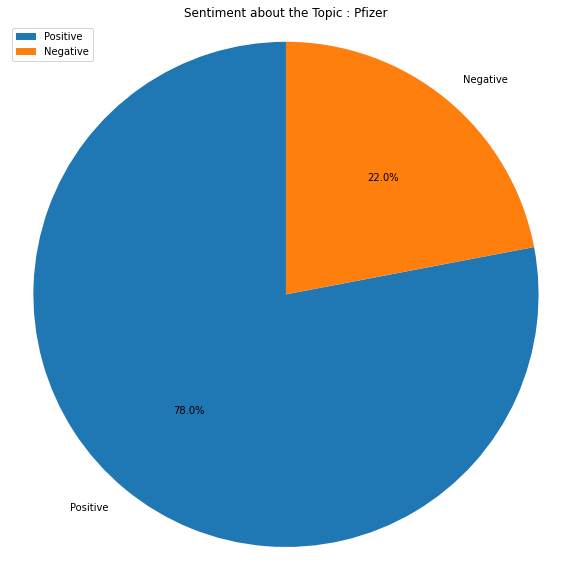

In [ ]:
result = df.value_counts(df['label'])
print("No. of tweets with POSITIVE sentiment in the collected set : ", result['POSITIVE'])
print("No. of tweets with NEGATIVE sentiment in the collected set", result['NEGATIVE'])
 
fig = plt.figure(figsize=(10,10))
plt.title("Sentiment about the Topic : "+MyTopic)
ax = fig.add_subplot(111)
ax.pie([result['POSITIVE'], result['NEGATIVE']], labels=['Positive', 'Negative'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.legend()
plt.show()

## Deployment

In [ ]:
consumer_key = "3bjTLuNoNNmJ38PDwu73zZf7H"
consumer_secret = "PuQK0cDKh45xrf6qNV5NIMYff9HQSRDjKmCr62MY3D9JbvQmbM"
access_key= "825051565685874688-QpPfgxkrwc0UbZeeWH18EF5xRMJMNyq"
access_secret = "gWCSzqPZWFDHPuOoh62tbcnSqmtIeFXJY21YE36ICdYR1"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

model_path = os.path.join("/content/drive/MyDrive/NLP PROJECT/"+KERAS_W2V_MODEL)
tokenizer_path = os.path.join("/content/drive/MyDrive/NLP PROJECT/"+TOKENIZER_MODEL)
model = load_model(model_path)
tokenizer = pickle.load(open(tokenizer_path, 'rb'))

def preprocess_tweet(tweet):
  # Remove link, user and special characters in the unprocessed tweet
  tweet = re.sub(TEXT_CLEANING_RE, ' ', str(tweet).lower()).strip()
  processed_words = []
  lemmatizer = WordNetLemmatizer()
  for word in tweet.split():
    if word not in stop_words:
      processed_words.append(word)

  # Lemmatizing the tokens
  processed_token = []
  for token, tag in pos_tag(processed_words):
    if tag.startswith("NN"):
        pos = 'n'
    elif tag.startswith('VB'):
        pos = 'v'
    else:
        pos = 'a'
    token = lemmatizer.lemmatize(token, pos)
    processed_token.append(token)

  #Final preprocessed tweet
  processed_tweet = " ".join(processed_token)
  return processed_tweet
  
def decode_sentiment(score, include_neutral=True):
  if include_neutral:        
    if score <= SENTIMENT_THRESHOLDS[0]: label = "NEGATIVE"
    elif score >= SENTIMENT_THRESHOLDS[1]: label = "POSITIVE"
    else : label = "NEUTRAL"
    return label
  else:
    return "NEGATIVE" if score < 0.5 else "POSITIVE"
 
def predict_tweet(text, include_neutral=True):
  # Tokenize text
  x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
  # Predict
  score = model.predict([x_test])[0]
  # Decode sentiment
  label = decode_sentiment(score, include_neutral=include_neutral)
  return {"label": label, "score": float(score)}
  
def analysis_my_topic(MyTopic,Tweets_count = 100):
  search_term = "#"+MyTopic+" -filter:retweets"
  tweets = tweepy.Cursor(api.search, q=search_term, count=100, lang="en", since_id=0).items(Tweets_count)
  tweet_texts = [tweet.text for tweet in tweets]
  score = list()
  label = list()
  for tweet_text in tweet_texts: 
    processed_tweet = preprocess_tweet(tweet_text)
    prediction = predict_tweet(processed_tweet,include_neutral=False)
    score.append(prediction['score'])
    label.append(prediction['label'])
  data = [[t,l,s] for t,l,s in zip(tweet_texts,label,score)]
  df = pd.DataFrame(data=data, columns=["tweets", "label", "score"])
  df.to_csv(MyTopic+'.csv')
  result = df.value_counts(df['label'])
  print("No. of tweets with POSITIVE sentiment in the collected set : ", result['POSITIVE'])
  print("No. of tweets with NEGATIVE sentiment in the collected set", result['NEGATIVE'])
 
  fig = plt.figure(figsize=(10,10))
  plt.title("Sentiment about the Topic : "+MyTopic)
  ax = fig.add_subplot(111)
  ax.pie([result['POSITIVE'], result['NEGATIVE']], labels=['Positive', 'Negative'], autopct='%1.1f%%', startangle=90)
  ax.axis('equal')
  ax.legend()
  plt.show()

Enter your name: covid
No. of tweets with POSITIVE sentiment in the collected set :  602
No. of tweets with NEGATIVE sentiment in the collected set 398


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


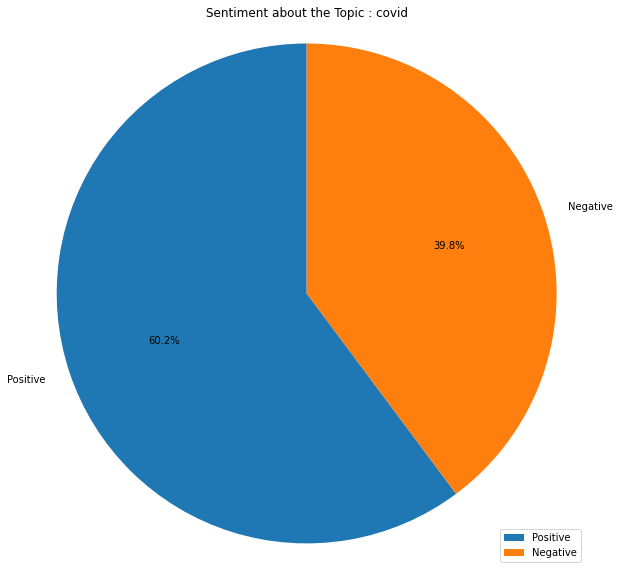

CPU times: user 2min 36s, sys: 5.07 s, total: 2min 41s
Wall time: 2min 3s


In [ ]:
%%time
UserTopic = input("Enter your name: ")
analysis_my_topic(UserTopic,1000)

Enter your name: intel
No. of tweets with POSITIVE sentiment in the collected set :  76
No. of tweets with NEGATIVE sentiment in the collected set 24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


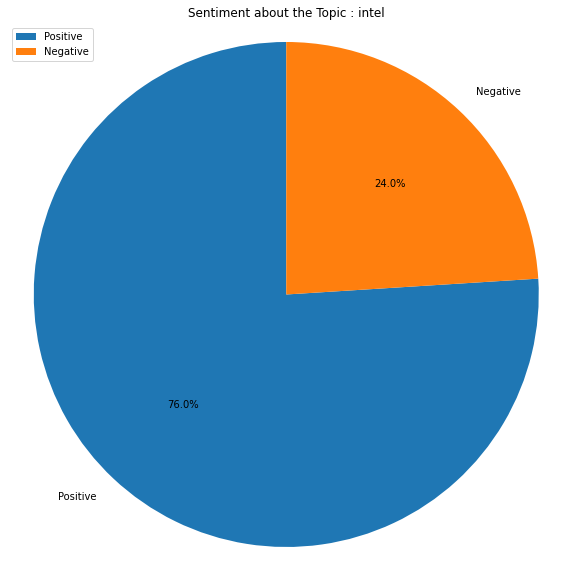

In [ ]:
UserTopic = input("Enter your name: ")
analysis_my_topic(UserTopic)

Enter your name: sputnik
No. of tweets with POSITIVE sentiment in the collected set :  71
No. of tweets with NEGATIVE sentiment in the collected set 29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


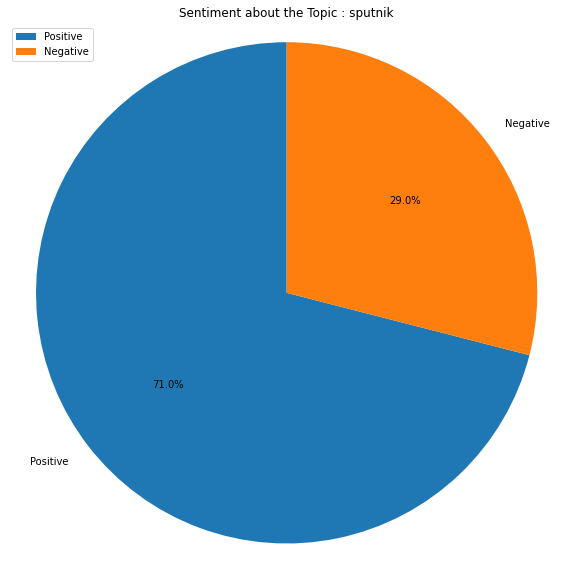

In [ ]:
UserTopic = input("Enter your name: ")
analysis_my_topic(UserTopic)

Enter your name: covishield
No. of tweets with POSITIVE sentiment in the collected set :  54
No. of tweets with NEGATIVE sentiment in the collected set 46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


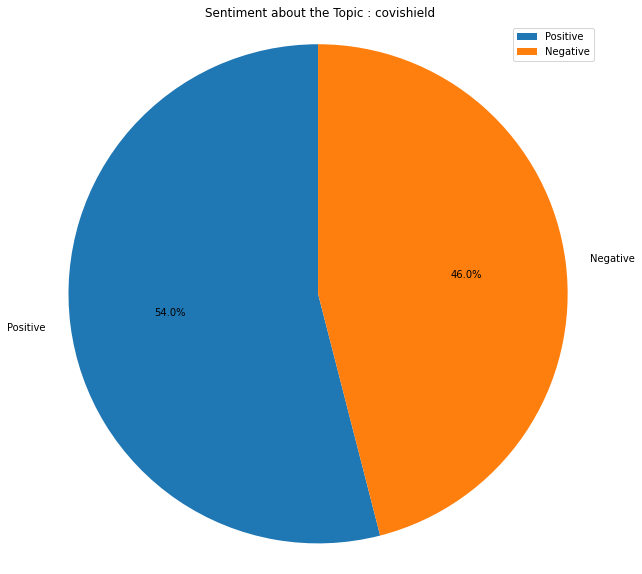

In [ ]:
UserTopic = input("Enter your name: ")
analysis_my_topic(UserTopic)

Enter your name: Autonomous
No. of tweets with POSITIVE sentiment in the collected set :  79
No. of tweets with NEGATIVE sentiment in the collected set 21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


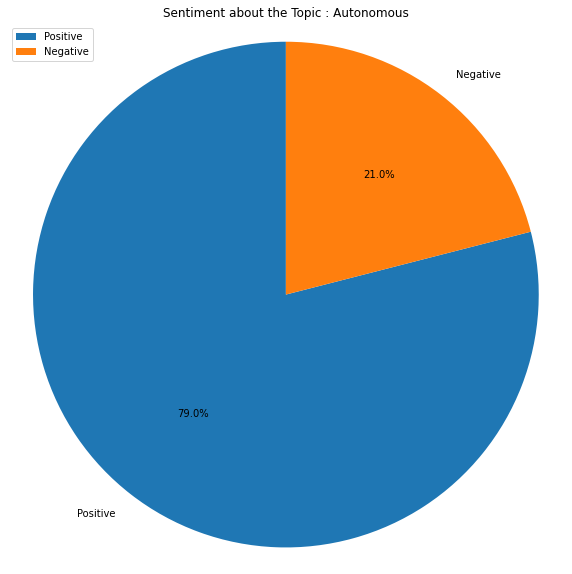

In [ ]:
UserTopic = input("Enter your name: ")
analysis_my_topic(UserTopic)